## Gravity-derived crustal structure on the Moon

In this practical, we'll look at some observations of gravity on the Moon and see what we can learn about crustal structure.

We'll try to reproduce some of the results of Wieczorek et al, 2013, The crust of the Moon as seen by GRAIL.

You can run cells with code in them.  Click in the cell and then press the run button or Shift+Enter.  Start by running the next four cells below to set up some software and load data.

In [2]:
# we'll need some software to start off with
# run this cell
import numpy as np
import pandas as pd
from scipy.special import sph_harm
import pyshtools as pysh
import matplotlib.pyplot as plt
import lunar_gravity_funs as lfuns
import cartopy
import pygmt

In [3]:
# some parameters to use for projection
prj=cartopy.crs.Mollweide()
prj='mollweide'

# and the coloring
cmap='gist_earth'
cmap='gist_ncar'
cmap='vik'

# figure size
plt.rcParams['figure.figsize'] = [12,8]


In [4]:
# read the gravity field derived from GRAIL by Lemoine et al, 2013
# this might take a minute---wait for the star to turn into a number

# open the file
import urllib.request
url='https://pds-geosciences.wustl.edu/grail/grail-l-lgrs-5-rdr-v1/grail_1001/shadr/gggrx_1200a_sha.tab'
req=urllib.request.urlopen(url)

# read a few reference paramters
hdr=req.readline().strip()
# moon radius in km
moon_rad=1.738e6
# gravitational constant times moon mass
GM=4.9028001224453001e3*1e9

# read all of the data
vls=np.loadtxt(req,dtype=float,delimiter=',',max_rows=45450)
req.close()

# figure out what the columns are
l,m=vls[:,0].astype(int),vls[:,1].astype(int)
lmax=np.max(l)
ix=l*(lmax+1)+m
data=np.zeros([2,(lmax+1)**2],dtype=float)
data[0,ix]=100*1000*GM/moon_rad**2*np.multiply(vls[:,2],l+1)
data[1,ix]=100*1000*GM/moon_rad**2*np.multiply(vls[:,3],l+1)
data=data.reshape([2,lmax+1,lmax+1])


# and put this in a convenient oject
data=pysh.SHCoeffs.from_array(data,normalization='4pi',copy=True)

In [5]:
# read the topography field

# open the file
import urllib.request
url='https://pds-geosciences.wustl.edu/lro/lro-l-lola-3-rdr-v1/lrolol_1xxx/data/lola_shadr/pa/lro_ltm01_pa_1080_sha.tab'
req=urllib.request.urlopen(url)

# moon radius in km
moon_rad=1.738e6

# read all of the data
vls=np.loadtxt(req,dtype=float,max_rows=45450)
req.close()

# figure out what the columns are
l,m=vls[:,0].astype(int),vls[:,1].astype(int)
lmax=np.max(l)
ix=l*(lmax+1)+m
topo=np.zeros([2,(lmax+1)**2],dtype=float)
topo[0,ix]=1/100*np.multiply(vls[:,2],l+1)
topo[1,ix]=1/100*np.multiply(vls[:,3],l+1)
topo=topo.reshape([2,lmax+1,lmax+1])


# and put this in a convenient oject
topo=pysh.SHCoeffs.from_array(topo,normalization='4pi',copy=True)

### Spherical harmonics

So we've now loaded all the data we need.  But before we go on, we'd like to understand the format that the data are in.  The data are defined by as a sum of spherical harmonics---the sines and cosines of a sphere.

Spherical harmonics are indexed by degree $l$ and order $m$.  Degree $l$ defines how quickly the function varies in all directions, and $m$ defines how quickly the function varies with longitude.  To see various types of spherical harmonics, try changing the values of l, m, ccf, and ssf in the cell below and re-running it.

The gravity and topography data we'll use are defined as a weighted sum of these functions.

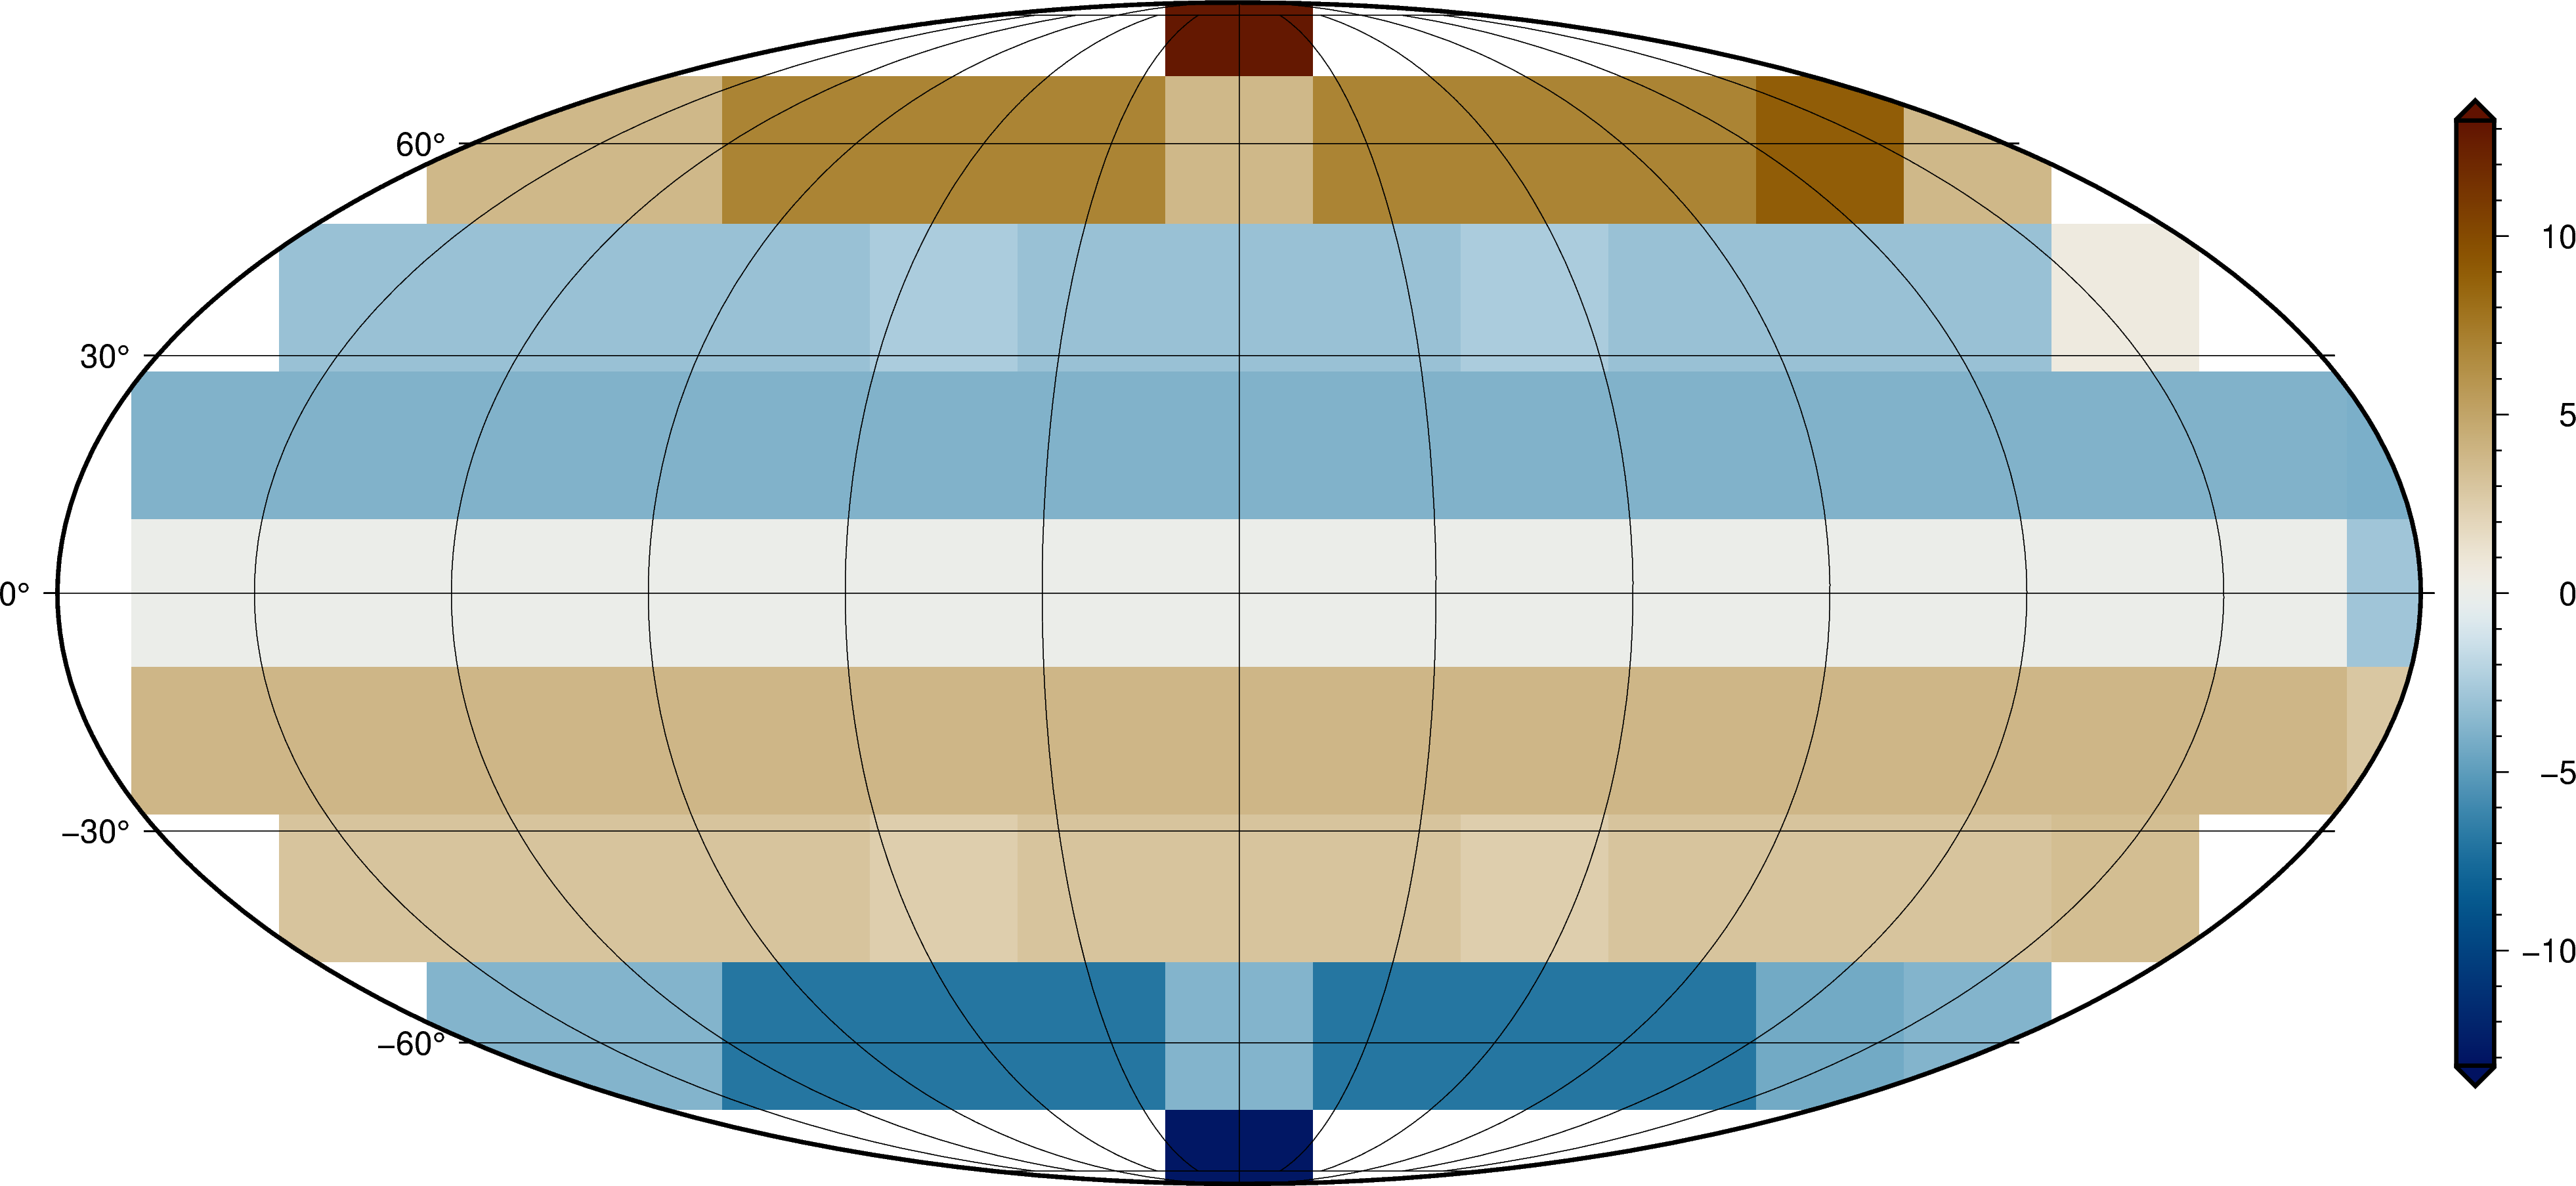

In [5]:
# choose the degree you want---how quickly the signal varies in all directions
l=np.array([3])

# choose the order you want---how quickly the signal varies with longitude
m=np.array([0])

# and choose the amplitude of the signal
# there are two coefficients for each frequency of variation: cosine and sine
ccf=np.array([5.])
scf=np.array([0.])

# don't bother changing what's below; it's just reformatting
lmax=np.max(l)
ix=l*(lmax+1)+m
excf=np.zeros([2,(lmax+1)**2],dtype=float)
excf[0,ix]=ccf
excf[1,ix]=scf
excf=excf.reshape([2,lmax+1,lmax+1])

# and put this in a convenient oject
excf=pysh.SHCoeffs.from_array(excf,normalization='4pi',copy=True)

excf_xyz=excf.expand(lat=np.arange(-90,90,.2))
fig=pygmt.Figure()
excf_xyz.plotgmt(projection=prj,cmap=cmap,colorbar='right',fig=fig);
fig.show()

### Plot the gravity and topography

Now let's go ahead and plot the gravity and topography data, running the two cells below.

The gravity data are the free air gravity: the gravitational acceleration that one would feel at a reference distance from the centre of the moon (1738 km in this instance).  They are measured in mgal.  1 mgal is equal to 0.1 ms$^{-2}$.

colorbar [WARNING]: GMT_Parse_Options: List interval-setting -B options before other axis -B options to ensure proper parsing.


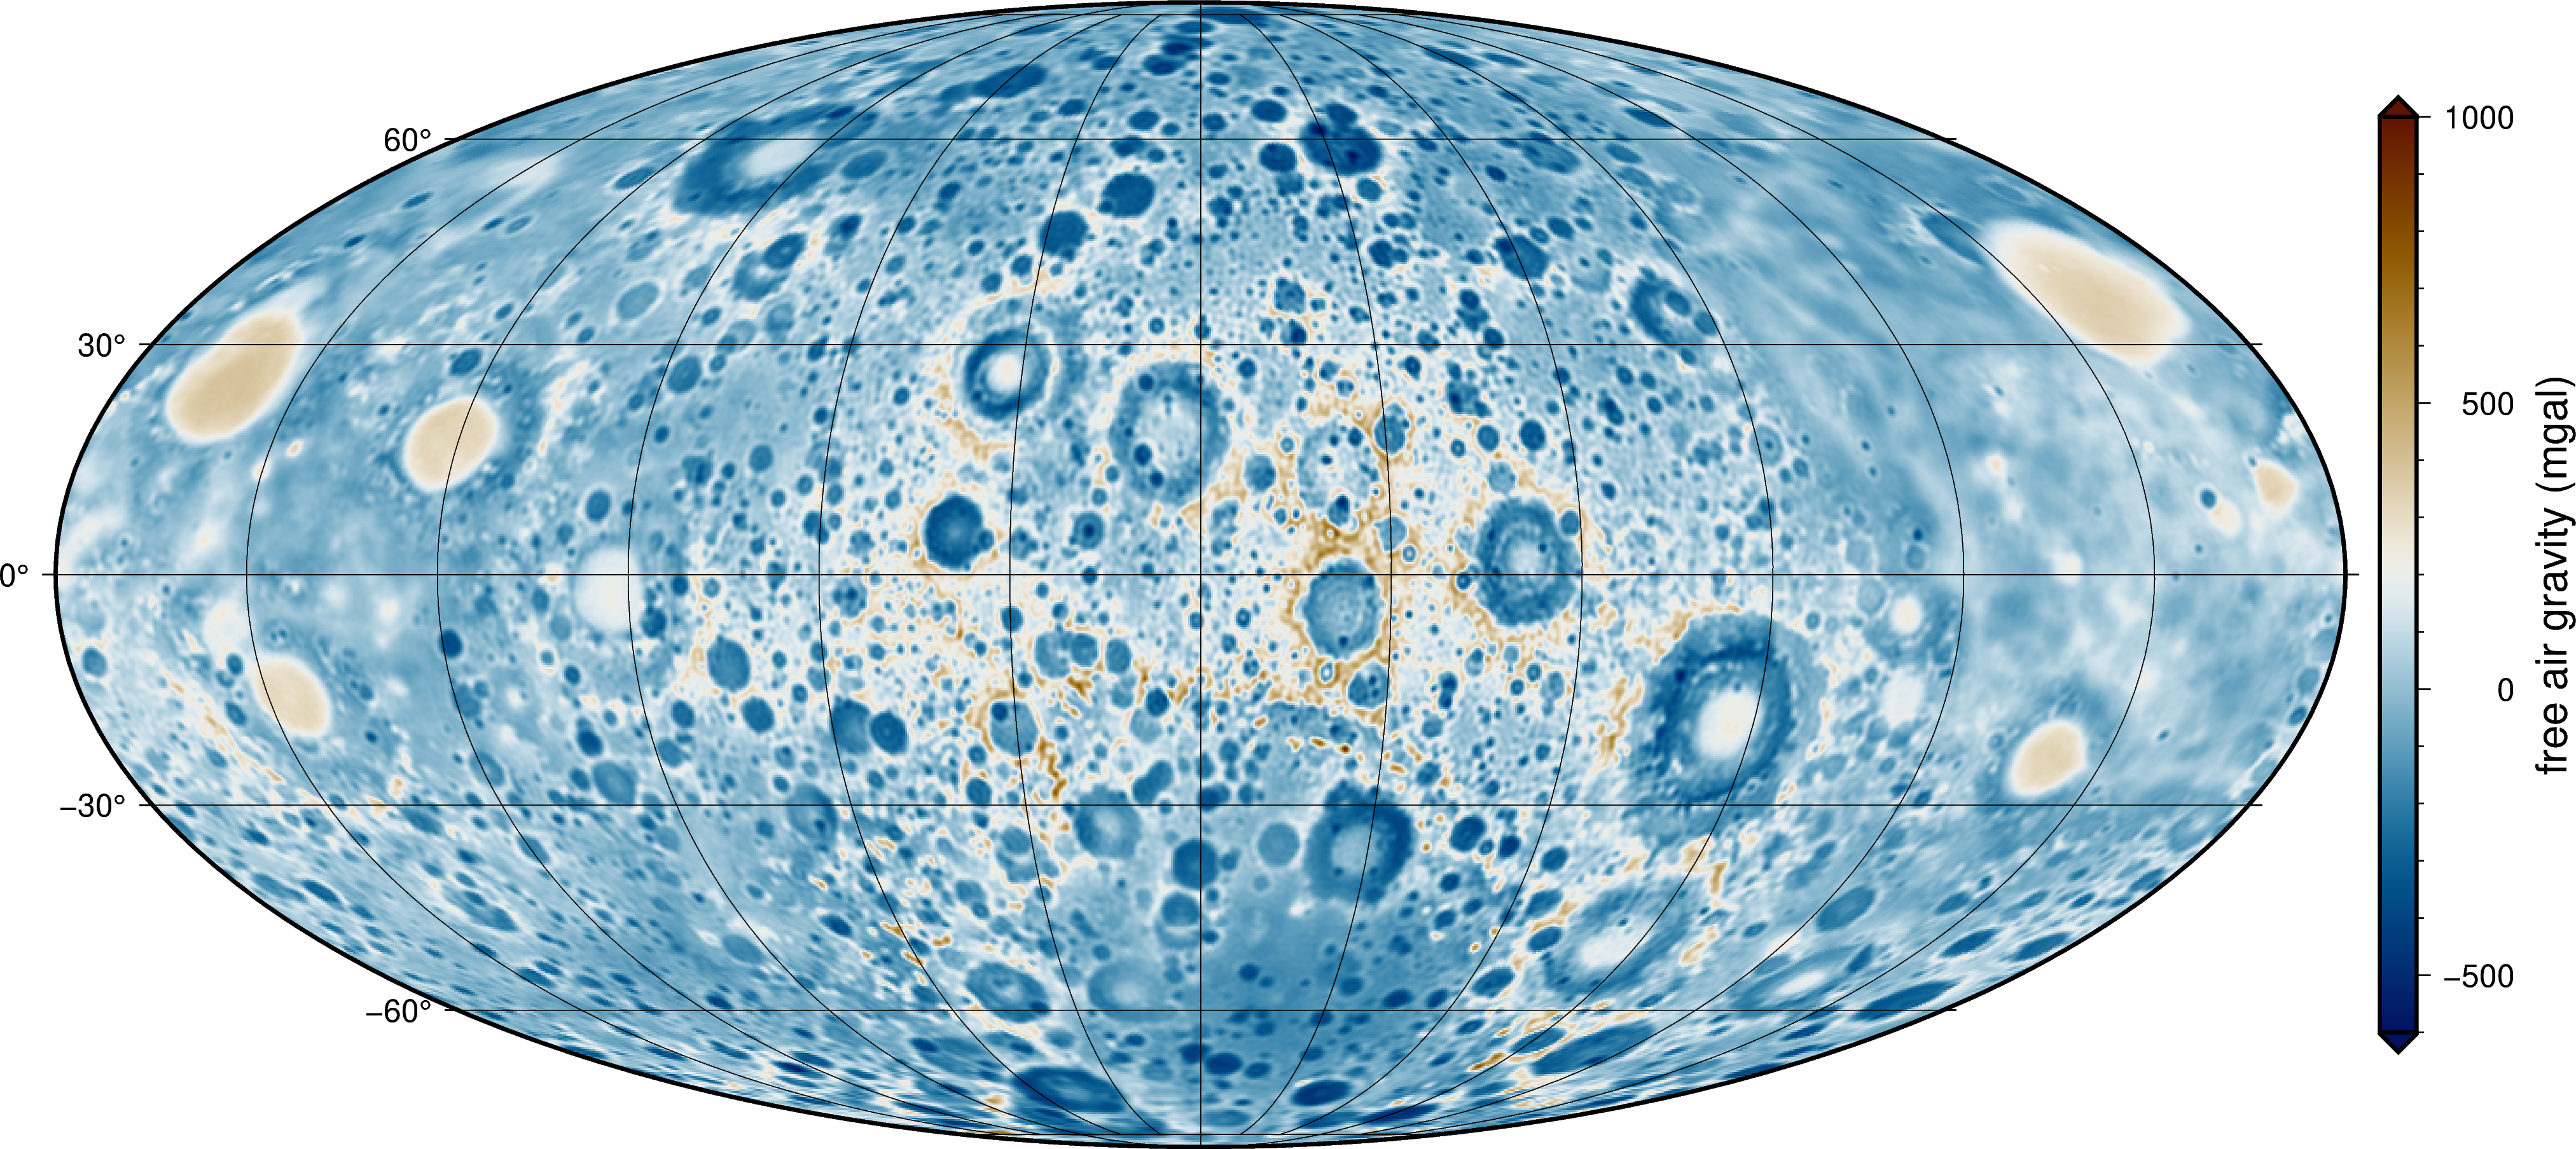

In [6]:
data_xyz=data.expand()
fig=pygmt.Figure()
data_xyz.plotgmt(projection=prj,cmap_limits=[-600,1000],cmap=cmap,fig=fig,central_longitude=180,
                 cb_label='free air gravity (mgal)',colorbar='right')
fig.show()


colorbar [WARNING]: GMT_Parse_Options: List interval-setting -B options before other axis -B options to ensure proper parsing.


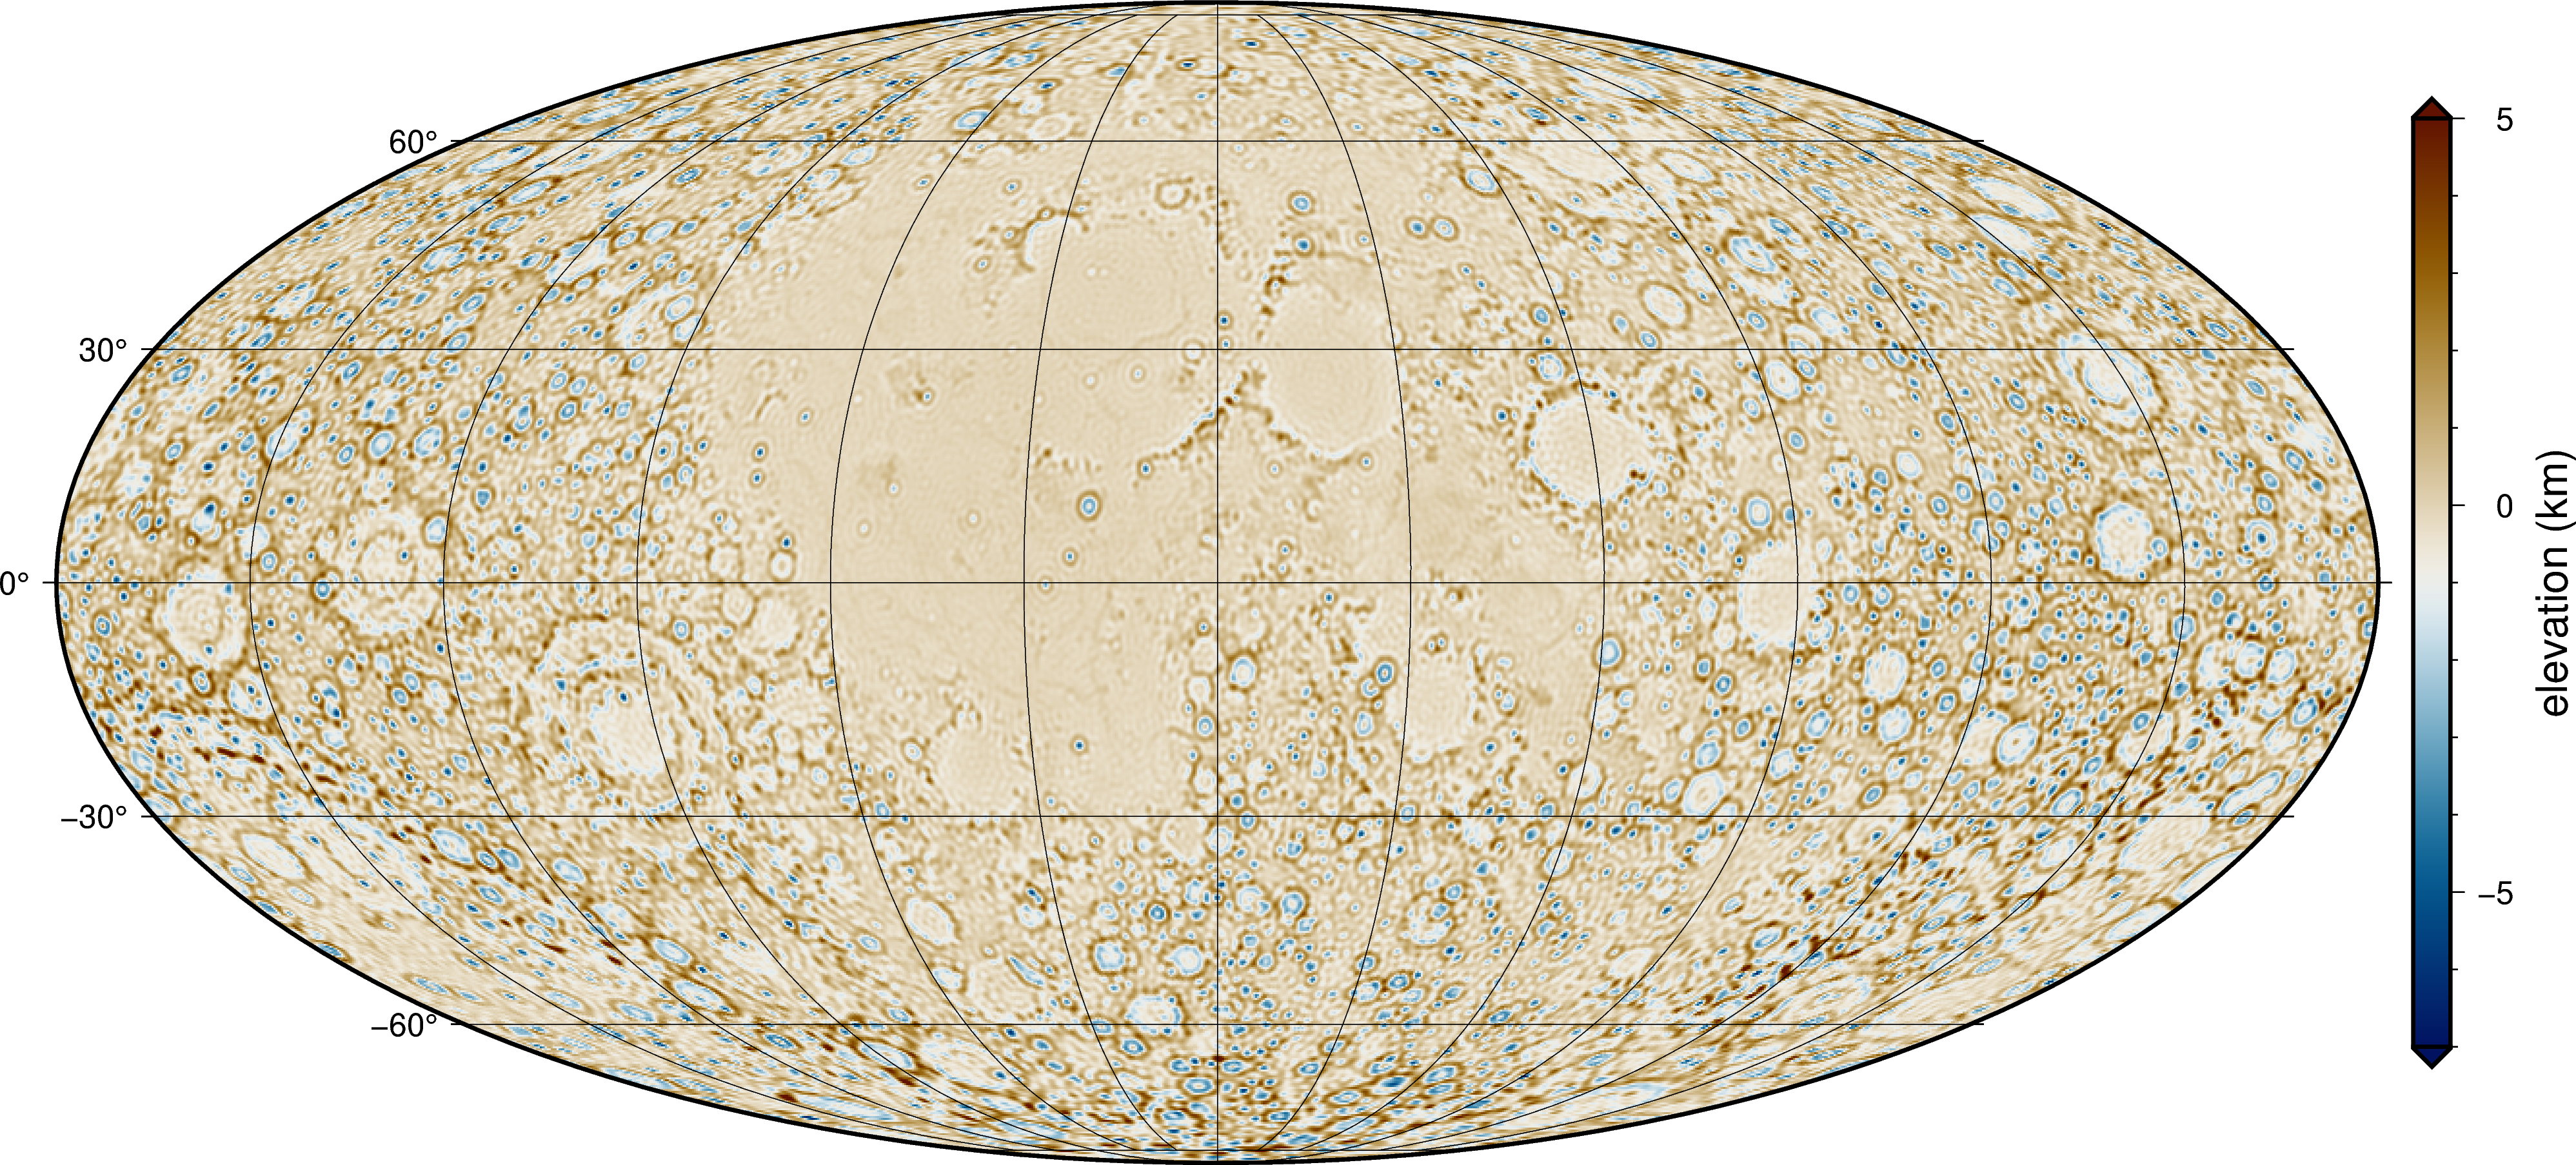

In [7]:
topo_xyz=topo.expand()
fig=pygmt.Figure()
topo_xyz.plotgmt(colorbar='right',cmap=cmap,cb_label='elevation (km)',
                    projection=prj,cmap_limits=[-7,5],fig=fig);
fig.show()

### Examine some maria

In [7]:
# define some longitude limits
lonlim=[-80,-50]
loncent=np.mean(lonlim)
# define some latitude limits
latlim=[0,30]
latcent=np.mean(latlim)
# and rearrange for input into the plotting function
extent=lonlim+latlim

colorbar [WARNING]: GMT_Parse_Options: List interval-setting -B options before other axis -B options to ensure proper parsing.


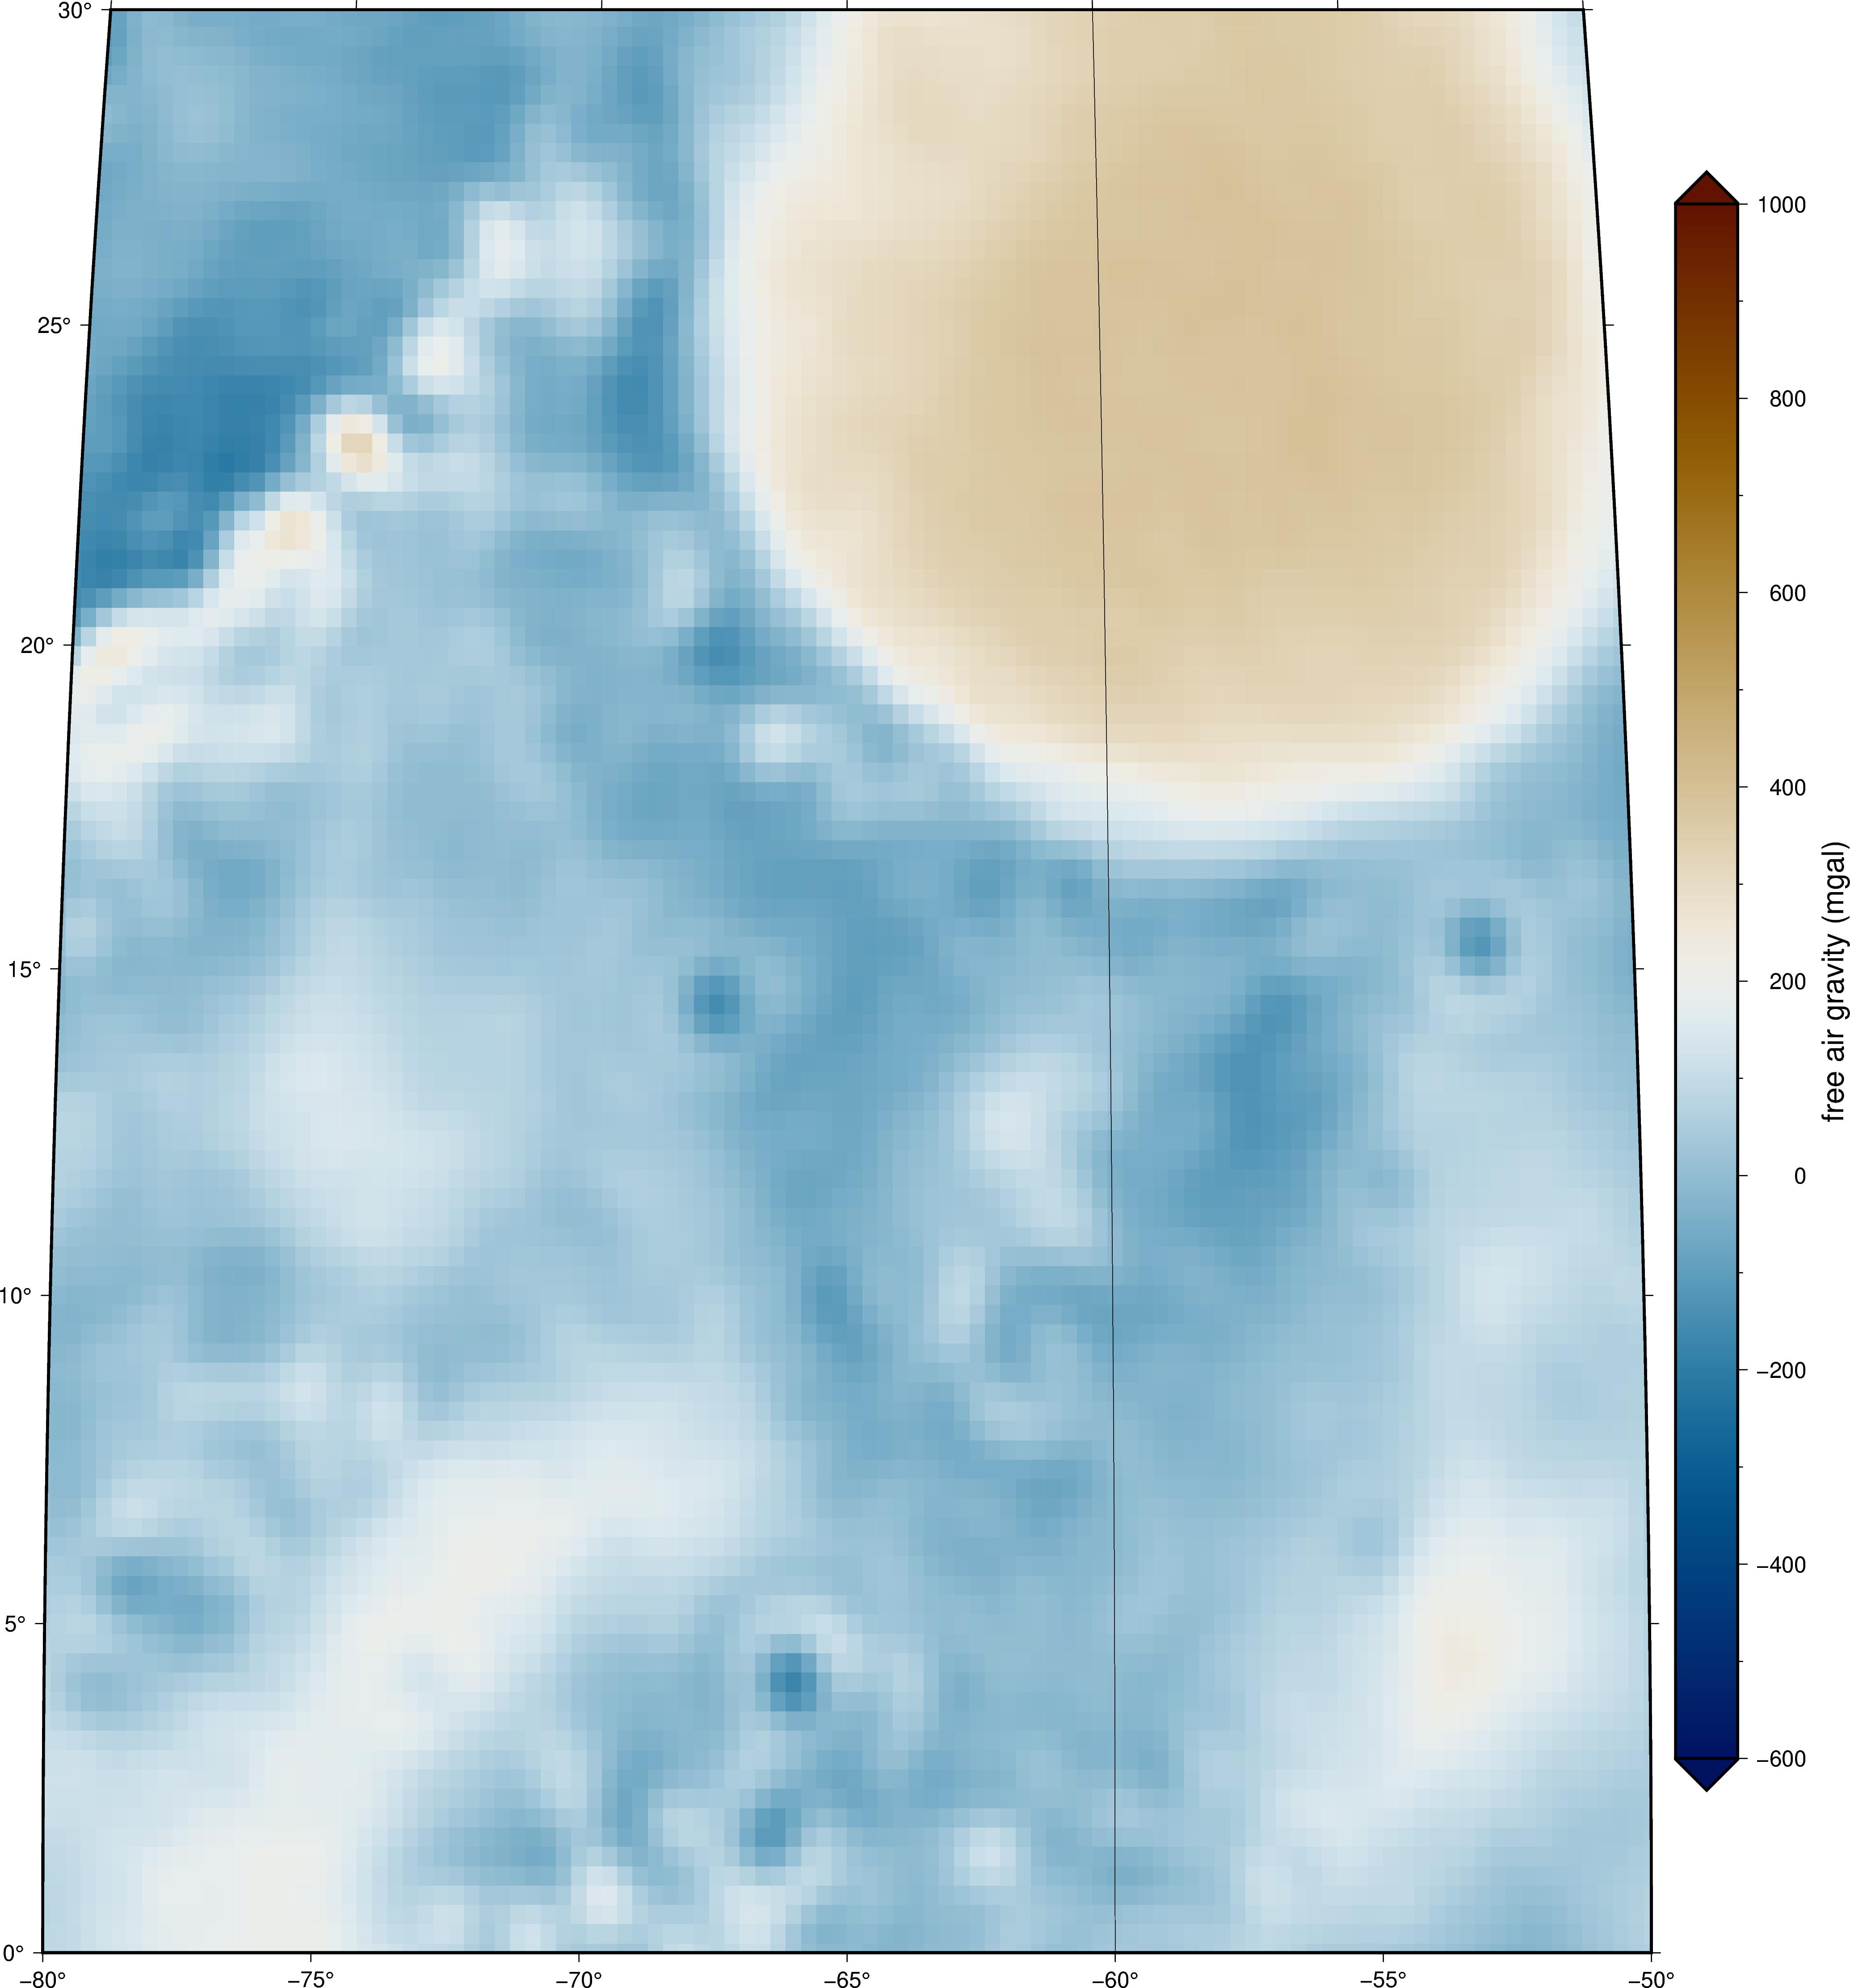

In [8]:
data_xyz=data.expand()
fig=pygmt.Figure()
data_xyz.plotgmt(projection=prj,cmap_limits=[-600,1000],cmap=cmap,fig=fig,
                 cb_label='free air gravity (mgal)',colorbar='right',
                 central_latitude=latcent,central_longitude=loncent,
                 region=extent,tick_interval=[5,5])
fig.show()

In [ ]:
topo_xyz=topo.expand()
fig=pygmt.Figure()
topo_xyz.plotgmt(projection=prj,cmap_limits=[-5,5],cmap=cmap,fig=fig,
                 cb_label='elevation (km)',colorbar='right',
                 central_latitude=latcent,central_longitude=loncent,
                 region=extent,tick_interval=[5,5])
fig.show()

### Average density of the crust

We now have two pieces of data: the topography of the Moon and the gravitational acceleration along the Moon's reference radius.  

In principle, we'd like much more information: the density of the Moon as a function of depth and location.  But let's start with something a bit simpler and just estimate the average density of the near-surface.  

It turns out to be relatively straightforward to calculate the gravity produced by a sharp step in density, even if the vertical location of the density step oscillates in space.  And that sharp step in density is exactly what we have with topography.  Density goes from the density of near-surface rocks just below the surface to zero just above it.  

The next two cells compute and plot the gravity expected for the defined lunar topography, assuming a density of 3 gcm$^3$ in the lunar crust.   This is the  Run them and compare with the observed gravity.  What's similar? What's different?

In [8]:
# pick a density in kg/m^3
density=3000

bc=pysh.SHGravCoeffs.from_shape((topo+1738)*1e3,
                                  rho=density,
                                  gm=42828372854187.76,
                                  lmax=np.max(topo.degrees()))*1000
bc=pysh.SHCoeffs.from_array(bc.coeffs*1e5,normalization='4pi',copy=True)

colorbar [WARNING]: GMT_Parse_Options: List interval-setting -B options before other axis -B options to ensure proper parsing.


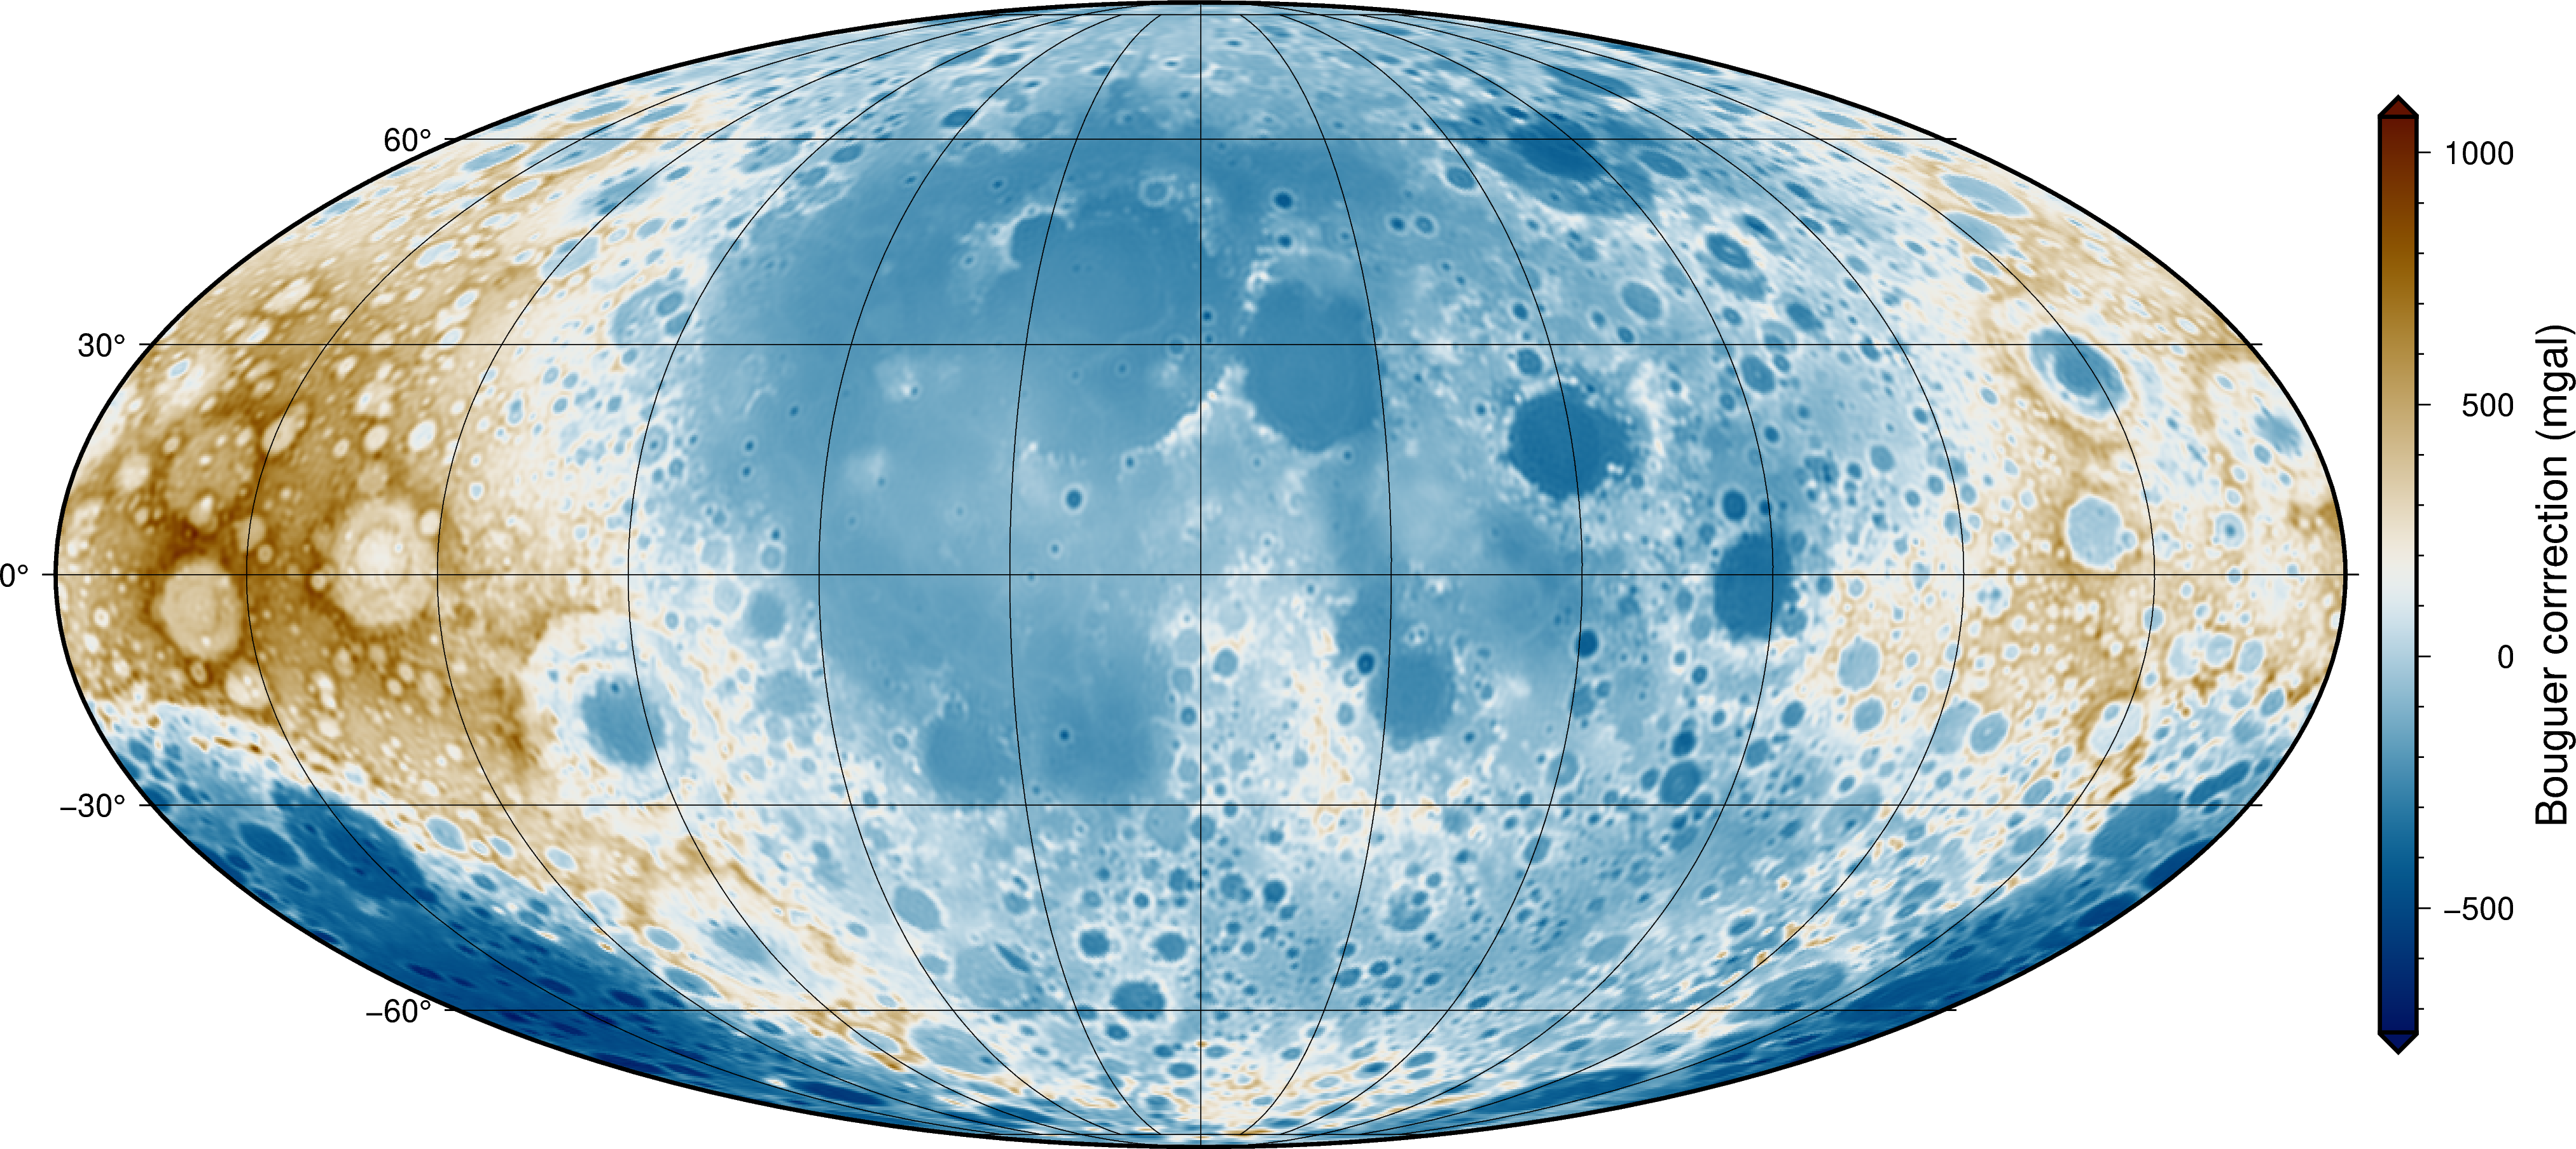

In [9]:
bc_xyz=bc.expand()

fig=pygmt.Figure()
bc_xyz.plotgmt(projection=prj,cmap=cmap,fig=fig,central_longitude=0,
                 cb_label='Bouguer corrrection (mgal)',colorbar='right')
fig.show()

### Which wavelength to compare?

The observed lunar field and the topography correction are clearly not the same on global map.  But maybe we'd find similarities if we only look at very short-wavelength or very long-wavelength oscillations in the field.  Which do you think is more likely to allow for similarity between the observations and the topography corrections?

The cell below allows you to remove long-wavelength or short-wavelength signals from the data and the topography predictions.  Try changing llow and lhigh to filter the data and run the following three cells to plot them in some range.  Is there a set of wavenumbers (degrees) that give a similar spatial pattern in the observations and the topographic prediction?

In [10]:
# choose a lower bound on the wavenumber (~1/wavelength)
# setting llow to a high number removes more long-wavelength signal
llow=5
# and an upper bound on the wavenumber
# setting lhigh to a small number removes more short-wavelength signal
lhigh=None

dataf=lfuns.filter_sph(data,llow=llow,lhigh=lhigh)
bcf=lfuns.filter_sph(bc,llow=llow,lhigh=lhigh)

/Users/eart0448/FILES/PYFILES/Courses/PlateTectonics/lunar_gravity_funs.py:29: RuntimeWarning: divide by zero encountered in true_divide
  amp[ilow]=np.power(llow/l[ilow],-n)


In [11]:
# define some longitude limits
lonlim=[0,90]
loncent=np.mean(lonlim)
# define some latitude limits
latlim=[0,90]
latcent=np.mean(latlim)
# and rearrange for input into the plotting function
extent=lonlim+latlim

/Applications/anaconda3/envs/normal/lib/python3.7/site-packages/pyshtools/shclasses/shcoeffsgrid.py:3864: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 864x432 with 2 Axes>,
 <AxesSubplot:xlabel='Longitude', ylabel='Latitude'>)

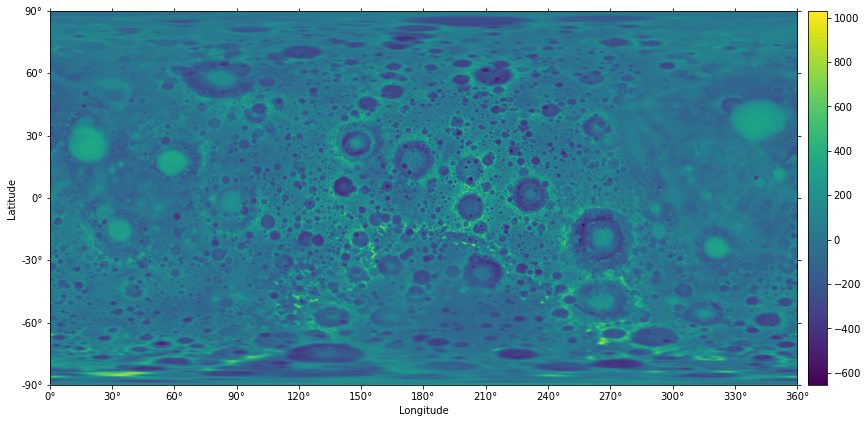

In [12]:
dataf_xyz=dataf.expand()
dataf_xyz.plot(colorbar='right')

In [1]:
dataf_xyz=dataf.expand()
fig=pygmt.Figure()
dataf_xyz.plotgmt(projection=prj,cmap_limits=[-600,1000],cmap=cmap,fig=fig,
                 cb_label='free air gravity (mgal)',colorbar='right',
                 central_latitude=latcent,central_longitude=loncent,
                 region=extent,tick_interval=[5,5])
fig.show()

NameError: name 'data' is not defined

In [ ]:
bcf_xyz=bcf.expand()
fig,ax=bcf_xyz.plot(colorbar='right',cmap=cmap,cb_label='Bouguer correction (mgal)',
                        projection=prj,cmap_limits=[0,200]);
ax.set_extent(extent)

### Density of the crust

Finally, let's determine the average density of the lunar crust.  Adjust the density in the cell that computes the topographic correction, and re-run the cells below it to replot and find a density that matches.  You'll probably have to play around with the colour scale (cmap_limits), and it may be interesting to look at several areas to see if you get the same density.

Analysis of lunar samples suggest that grains in anorthositic crust have a density of 2800 to 2900 kgm$^3$, and grains in basaltic crust have a density of 3300 to 3500 kgm$^3$ (Kiefer et al, 2012).  What do you conclude about the porosity of the lunar crust?

### Remove the topography

Now that we know the density of the crust, we can subtract the effect of topography.  This is the Bouguer corrrection.  Enter the correct density above, and run the cell below to subtract the topographic correction and isolate the Bouguer analomy, produced by deeper signals.

In [ ]:
# compute the Bouguer anomaly
ba = data - bc

In [ ]:
ba_xyz=ba.expand()
fig,ax=ba_xyz.plot(colorbar='right',cmap=cmap,cb_label='Bouguer gravity anomaly (mgal)',
                      projection=prj);

### Crustal thickness

In [ ]:
# choose an average depth of the lunar crust, in km
avdep=40.

# create a grid of locations
lon,lat=np.meshgrid(np.arange(0,360,1),np.arange(-90,90,1))
depths=np.ones(lon.shape,dtype=float)*avdep

# but let's put a locally deeper or shallower crust somewhere
# the local depth
ldep=10
# the anomaly location, in degrees
a_longitude=10.
a_latitude=5.
# the anomaly half-width, in degrees latitude
a_width=3.

# add this anomaly
# distances from the anomaly squared (roughly---not spherical distances)
lrat=np.cos(a_latitude*np.pi/180)
d2 = np.power(lat-a_latitude,2) + np.power(lon-a_longitude,2)*lrat**2
depths=depths+(ldep-avdep)*np.exp(-d2/a_width**2)

# make this into a set of spherical harmonic coefficients
dep_xyz=pysh.SHGrid.from_array(depths)
fig,ax=dep_xyz.plot(colorbar='right',cmap=cmap,cb_label='Moho depth (km)',
                      projection=prj);
dep=dep_xyz.expand()

In [ ]:
# pick a density contrast in kg/m^3
density_contrast=200

# and compute the gravity anomaly produced by the Moho
pred=pysh.SHGravCoeffs.from_shape((1738-dep)*1e3,
                                  rho=density_contrast,
                                  gm=42828372854187.76,
                                  lmax=np.max(dep.degrees()))*1000
pred = pred.change_ref(r0=1738000)
pred=pysh.SHCoeffs.from_array(pred.coeffs*1e5,normalization='4pi',copy=True)

In [ ]:
# define some longitude limits
lonlim=[-10,10]
loncent=np.mean(lonlim)
# define some latitude limits
latlim=[0,30]
latcent=np.mean(latlim)
# and rearrange for input into the plotting function
extent=lonlim+latlim

In [ ]:
ba_xyz=ba.expand()
fig,ax=ba_xyz.plot(colorbar='right',cmap=cmap,cb_label='Bouguer gravity (mgal)',
                        cmap_limits=[-800,1000],projection=prj);
#ax.set_extent(extent)

In [ ]:
pred_xyz=pred.expand()
fig,ax=pred_xyz.plot(colorbar='right',cmap=cmap,cb_label='predicted Bouguer gravity (mgal)',
                        cmap_limits=[-800,1000],projection=prj);
#ax.set_extent(extent)